In [1]:
!python --version

Python 3.7.6


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
import tensorflow as tf
print(tf.test.is_gpu_available()) 
# If this is False, your drivers/libraries are mismatched.

True


In [4]:
!git clone https://github.com/akTwelve/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 979, done.
remote: Total 979 (delta 0), reused 0 (delta 0), pack-reused 979 (from 1)
Receiving objects: 100% (979/979), 137.72 MiB | 38.91 MiB/s, done.
Resolving deltas: 100% (570/570), done.


In [5]:
import os
os.chdir('Mask_RCNN')

In [6]:
!python3 setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/

In [7]:
ls

LICENSE      assets/  images/              requirements.txt  setup.py
MANIFEST.in  build/   mask_rcnn.egg-info/  samples/
README.md    dist/    mrcnn/               setup.cfg


In [8]:
import sys
sys.path.append(os.path.join("/kaggle/working/", 'Mask_RCNN'))

In [9]:
sys.path.append(os.path.join("/kaggle/input/coco-py/"))

In [ ]:
!pip install pycocotools

In [11]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
import mrcnn

In [12]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


In [30]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import time
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = "/kaggle/working/logs"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join("/kaggle/working/Mask_RCNN/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join("/kaggle/input/markerpensseg/markerpensseg/valid")

In [15]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [16]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [17]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


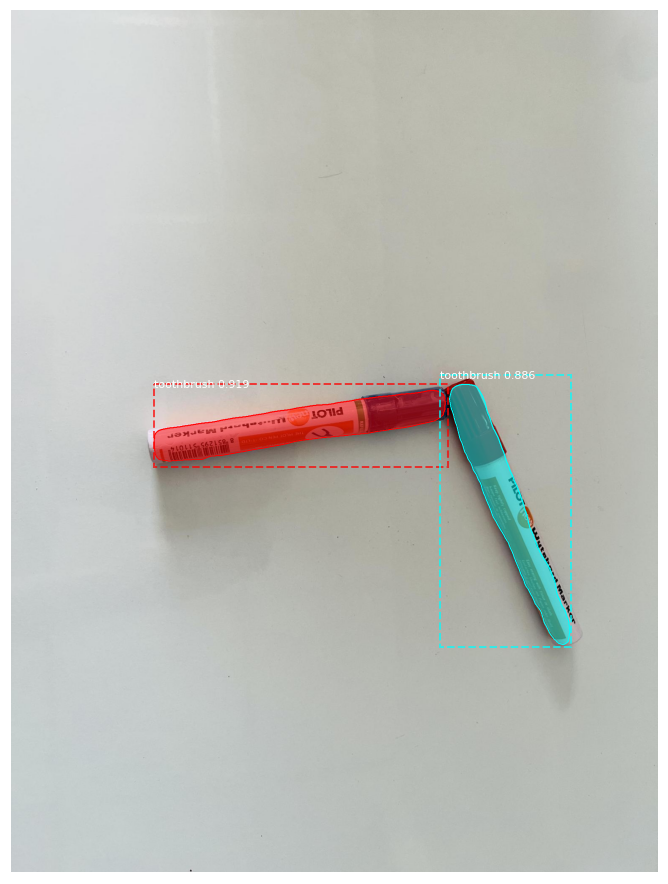

In [21]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [22]:
import json
from collections import defaultdict
from pprint import pprint

def check_coco_instance_segmentation(ann_file_path):
    with open(ann_file_path, 'r') as f:
        coco_data = json.load(f)

    # Top-level keys
    assert 'images' in coco_data, "'images' key not found"
    assert 'annotations' in coco_data, "'annotations' key not found"
    assert 'categories' in coco_data, "'categories' key not found"

    print(f"📷 Total images: {len(coco_data['images'])}")
    print(f"✏️ Total annotations: {len(coco_data['annotations'])}")
    print(f"🏷️ Total categories: {len(coco_data['categories'])}")

    print("\n🔍 Sample category definitions:")
    pprint(coco_data['categories'])

    # Required annotation fields
    required_fields = {"id", "image_id", "bbox", "category_id", "segmentation"}
    optional_fields = ["iscrowd", "area"]
    missing_fields = defaultdict(list)
    bad_segmentations = []

    for i, ann in enumerate(coco_data['annotations']):
            for field in required_fields:
                if field not in ann:
                    missing_fields[field].append(i)
    
            # Check segmentation format: must be non-empty polygon(s)
            seg = ann.get("segmentation", [])
            if not isinstance(seg, list) or len(seg) == 0:
                bad_segmentations.append((i, "Empty or invalid segmentation"))
            else:
                for poly in seg:
                    if not isinstance(poly, list) or len(poly) < 6 or len(poly) % 2 != 0:
                        bad_segmentations.append((i, f"Invalid polygon: {poly}"))
    
    # Report missing fields
    for field, indices in missing_fields.items():
        print(f"⚠️ Missing '{field}' in {len(indices)} annotations. Examples: {indices[:5]}")
    if not missing_fields:
        print("✅ All required fields are present in every annotation")

    # Report segmentation issues
    if bad_segmentations:
        print(f"⚠️ Found {len(bad_segmentations)} invalid/malformed segmentations.")
        for i, reason in bad_segmentations[:5]:
            print(f"  Annotation {i}: {reason}")
    else:
        print("✅ All segmentations are well-formed polygons")

    # Optional fields
    for field in optional_fields:
        missing = sum(1 for ann in coco_data['annotations'] if field not in ann)
        if missing > 0:
            print(f"⚠️ Missing optional '{field}' in {missing} annotations")
        else:
            print(f"✅ All annotations have optional field '{field}'")

# Example usage:
check_coco_instance_segmentation("/kaggle/input/markerpensseg/markerpensseg/train/_annotations.coco.json")
check_coco_instance_segmentation("/kaggle/input/markerpensseg/markerpensseg/valid/_annotations.coco.json")

📷 Total images: 225
✏️ Total annotations: 450
🏷️ Total categories: 2

🔍 Sample category definitions:
[{'id': 0, 'name': 'caps-7o2C', 'supercategory': 'none'},
 {'id': 1, 'name': 'CAP', 'supercategory': 'caps-7o2C'}]
✅ All required fields are present in every annotation
✅ All segmentations are well-formed polygons
✅ All annotations have optional field 'iscrowd'
✅ All annotations have optional field 'area'
📷 Total images: 30
✏️ Total annotations: 60
🏷️ Total categories: 2

🔍 Sample category definitions:
[{'id': 0, 'name': 'caps-7o2C', 'supercategory': 'none'},
 {'id': 1, 'name': 'CAP', 'supercategory': 'caps-7o2C'}]
✅ All required fields are present in every annotation
✅ All segmentations are well-formed polygons
✅ All annotations have optional field 'iscrowd'
✅ All annotations have optional field 'area'


In [24]:
from pycocotools.coco import COCO
import numpy as np
import skimage.draw
import os

class MarkerpensDataset(utils.Dataset):

    def load_coco(self, image_dir, annotation_json):
        """
        image_dir: path to images/train or images/valid
        annotation_json: instances_train.json or instances_valid.json
        """

        coco = COCO(annotation_json)

        # ---- Classes ----
        class_ids = sorted(coco.getCatIds())
        for cid in class_ids:
            cat = coco.loadCats(cid)[0]
            self.add_class(
                source="dataset",
                class_id=cid,
                class_name=cat["name"]
            )

        # ---- Images ----
        image_ids = coco.getImgIds()
        for img_id in image_ids:
            img = coco.loadImgs(img_id)[0]
            self.add_image(
                source="dataset",
                image_id=img_id,
                path=os.path.join(image_dir, img["file_name"]),
                width=img["width"],
                height=img["height"],
                annotations=coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))
            )

        self.coco = coco

    def load_mask(self, image_id):
        """
        Returns:
          masks: [H, W, N]
          class_ids: [N]
        """

        info = self.image_info[image_id]
        anns = info["annotations"]

        masks = []
        class_ids = []

        height = info["height"]
        width = info["width"]

        for ann in anns:
            if ann.get("iscrowd", 0):
                continue

            mask = np.zeros((height, width), dtype=np.uint8)

            for seg in ann["segmentation"]:
                poly = np.array(seg).reshape((-1, 2))
                rr, cc = skimage.draw.polygon(poly[:, 1], poly[:, 0], mask.shape)
                mask[rr, cc] = 1

            masks.append(mask)
            class_ids.append(ann["category_id"])

        if masks:
            masks = np.stack(masks, axis=-1)
            class_ids = np.array(class_ids, dtype=np.int32)
            return masks, class_ids
        else:
            return np.empty((height, width, 0)), np.array([], dtype=np.int32)

    def image_reference(self, image_id):
        return self.image_info[image_id]["path"]

In [25]:
dataset_train = MarkerpensDataset()
dataset_train.load_coco(
    image_dir="/kaggle/input/markerpensseg/markerpensseg/train",
    annotation_json="/kaggle/input/markerpensseg/markerpensseg/train/_annotations.coco.json"
)
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))

dataset_val = MarkerpensDataset()
dataset_val.load_coco(
    image_dir="/kaggle/input/markerpensseg/markerpensseg/valid",
    annotation_json="/kaggle/input/markerpensseg/markerpensseg/valid/_annotations.coco.json"
)
dataset_val.prepare()
print('Valid: %d' % len(dataset_val.image_ids))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Train: 225
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Valid: 30


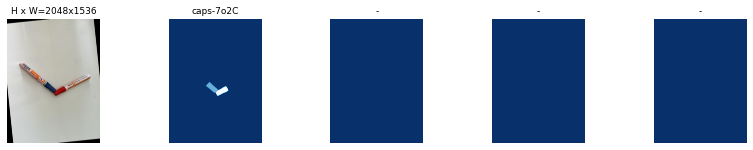

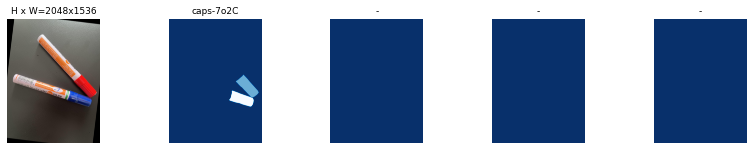

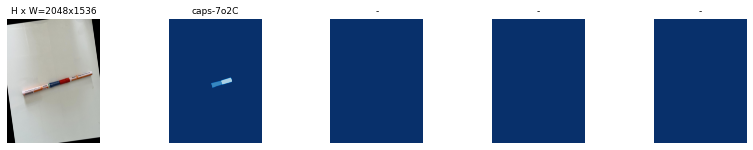

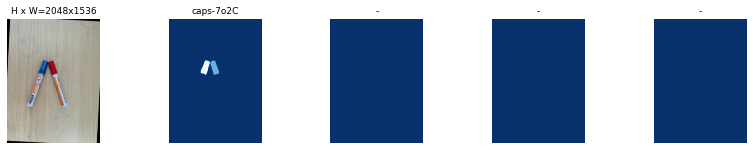

In [26]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [44]:
class MarkerpensConfig(Config):
    # Give the configuration a recognizable name
    NAME = "Markerpens_segmentation"
    
    NUM_CLASSES = 1 + 2

    # Set batch size to 1
    # Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    STEPS_PER_EPOCH = 225
    VALIDATION_STEPS = 30

config = MarkerpensConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [45]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 5


In [31]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')
history = model.keras_model.history.history.copy()


Starting at epoch 0. LR=0.001

Checkpoint Path: /kaggle/working/logs/markerpens_segmentation20260129T1801/mask_rcnn_markerpens_segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


225/225 [==============================] - 171s 762ms/step - loss: 1.4302 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.7797 - mrcnn_class_loss: 0.1302 - mrcnn_bbox_loss: 0.3606 - mrcnn_mask_loss: 0.1295 - val_loss: 0.9329 - val_rpn_class_loss: 0.0050 - val_rpn_bbox_loss: 0.4659 - val_mrcnn_class_loss: 0.0795 - val_mrcnn_bbox_loss: 0.2808 - val_mrcnn_mask_loss: 0.1017
Epoch 2/5
225/225 [==============================] - 89s 394ms/step - loss: 0.4958 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2449 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.0735 - val_loss: 0.7683 - val_rpn_class_loss: 0.0067 - val_rpn_bbox_loss: 0.4476 - val_mrcnn_class_loss: 0.0464 - val_mrcnn_bbox_loss: 0.1652 - val_mrcnn_mask_loss: 0.1024
Epoch 3/5
225/225 [==============================] - 90s 402ms/step - loss: 0.4620 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2400 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.0707 - val_loss: 0.5531 - val_rpn_class_loss: 0

In [32]:
print(history)

{'loss': [1.430163523885939, 0.4958431231975555, 0.46203616380691526, 0.37345235354370543, 0.30797450529204473], 'rpn_class_loss': [0.030160613, 0.006875902, 0.0062498096, 0.0060448353, 0.0052837734], 'rpn_bbox_loss': [0.7796928, 0.24491028, 0.24003088, 0.20630263, 0.17107998], 'mrcnn_class_loss': [0.13016224, 0.045404162, 0.04968229, 0.02775323, 0.03092044], 'mrcnn_bbox_loss': [0.36061364, 0.12511152, 0.0954063, 0.07406503, 0.04907134], 'mrcnn_mask_loss': [0.12953424, 0.07354125, 0.07066681, 0.05928661, 0.051618993], 'val_loss': [0.9329175432523091, 0.768330184618632, 0.5530573050181071, 0.6750989039738973, 0.3850714405377706], 'val_rpn_class_loss': [0.0049925894, 0.0066826004, 0.0044995635, 0.0071253288, 0.006465657], 'val_rpn_bbox_loss': [0.46593273, 0.44759074, 0.26131192, 0.2888743, 0.18922456], 'val_mrcnn_class_loss': [0.07951338, 0.04644011, 0.06073595, 0.11724271, 0.028545432], 'val_mrcnn_bbox_loss': [0.28077945, 0.165215, 0.15357082, 0.19420394, 0.09434688], 'val_mrcnn_mask_lo

In [48]:
# # Fine tune all layers
# # Passing layers="all" trains all layers. You can also 
# # pass a regular expression to select which layers to
# # train by name pattern.
# start_train = time.time()
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=10, 
#             layers="all")
# end_train = time.time()
# minutes = round((end_train - start_train) / 60, 2)
# print(f'Training took {minutes} minutes')
# s = model.keras_model.history.history
# for k in s: history[k] = history[k] + s[k]

In [50]:
import pandas as pd

In [51]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss
1,1.430164,0.030161,0.779693,0.130162,0.360614,0.129534,0.932918,0.004993,0.465933,0.079513,0.280779,0.101699
2,0.495843,0.006876,0.244910,0.045404,0.125112,0.073541,0.768330,0.006683,0.447591,0.046440,0.165215,0.102402
3,0.462036,0.006250,0.240031,0.049682,0.095406,0.070667,0.553057,0.004500,0.261312,0.060736,0.153571,0.072939
4,0.373452,0.006045,0.206303,0.027753,0.074065,0.059287,0.675099,0.007125,0.288874,0.117243,0.194204,0.067653
5,0.307975,0.005284,0.171080,0.030920,0.049071,0.051619,0.385071,0.006466,0.189225,0.028545,0.094347,0.066489


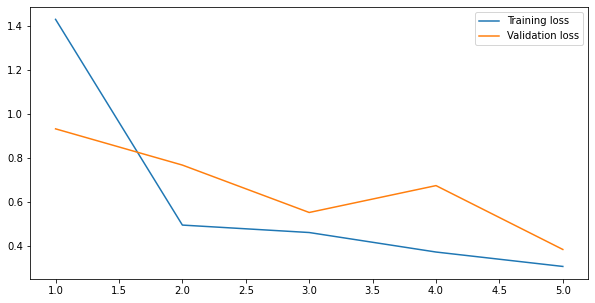

In [52]:
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.plot(epochs, history["loss"], label="Training loss")
plt.plot(epochs, history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

In [53]:
class InferenceConfig(MarkerpensConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = "/kaggle/working/logs/markerpens_segmentation20260129T1801/mask_rcnn_markerpens_segmentation_0005.h5"
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/working/logs/markerpens_segmentation20260129T1801/mask_rcnn_markerpens_segmentation_0005.h5
Re-starting from epoch 5


In [60]:
class_names = ['BG', 'CAP', 'CAP']

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


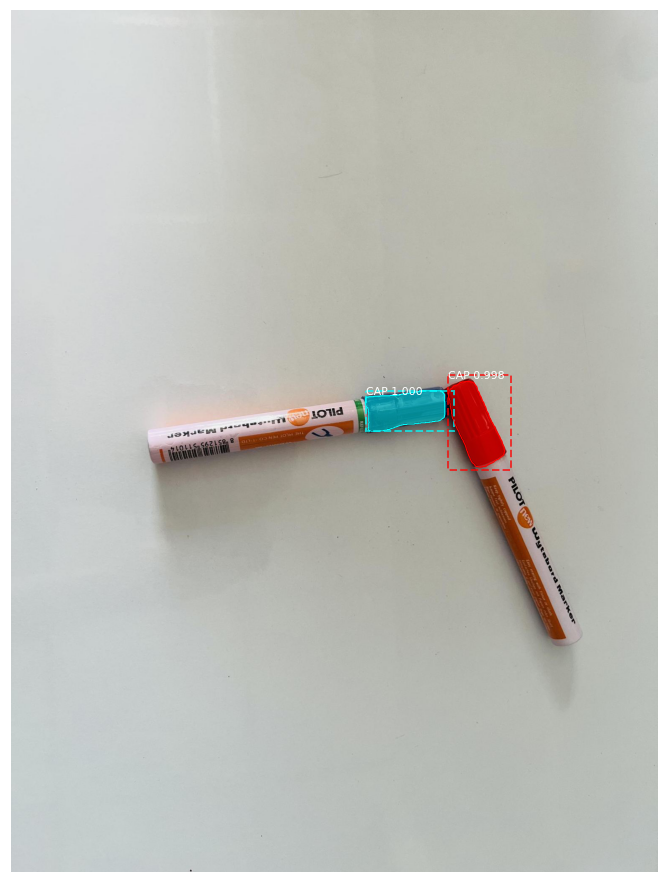

In [61]:
# Load a random image from the images folder
file_names = next(os.walk("/kaggle/input/markerpensseg/markerpensseg/valid"))[2]
image = skimage.io.imread(os.path.join("/kaggle/input/markerpensseg/markerpensseg/valid", random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 2048.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  513.00000  max:  693.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  uint8


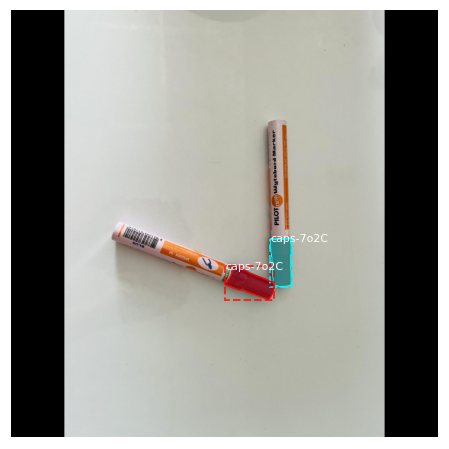

In [39]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [40]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


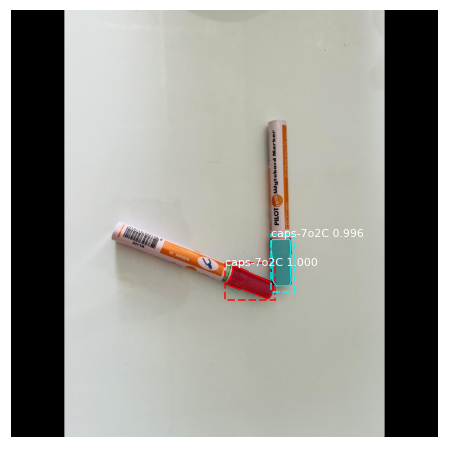

In [41]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


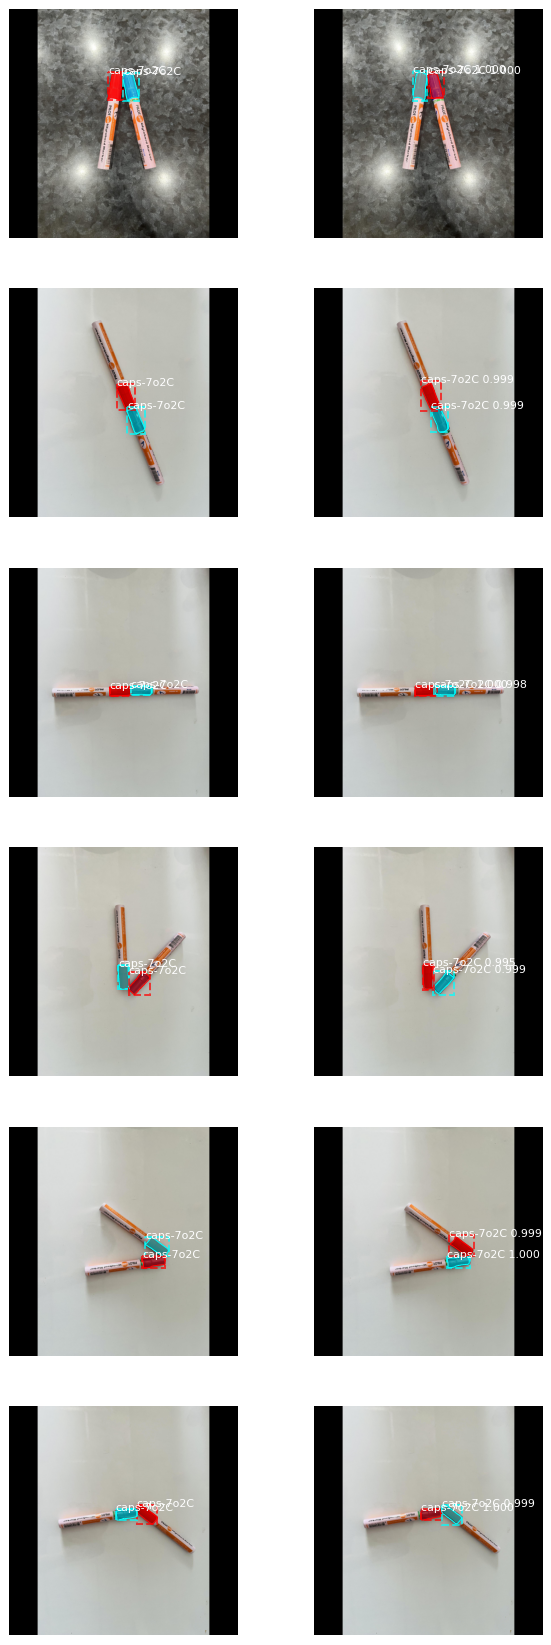

In [42]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                ax=fig.axes[-1])

In [ ]:
!zip -r /kaggle/working/maskrcnnmarkerpensfiles.zip /kaggle/working/

In [67]:
!rm /kaggle/working/logs/markerpens_segmentation20260129T1801/mask_rcnn_markerpens_segmentation_0004.h5

In [68]:
!rm /kaggle/working/Mask_RCNN/mask_rcnn_coco.h5

In [ ]:
# !rm /kaggle/working/maskrcnnmarkerpensfiles.zip

In [63]:
# # Convert to TFLite. This form of quantization is called
# # post-training dynamic-range quantization in TFLite.
# keras_model = model.keras_model
# converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
# converter.allow_custom_ops = True
# converter.experimental_new_converter = True
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
#     tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
# ]

# converter.optimizations = [ tf.lite.Optimize.DEFAULT ]

# # No optimizations
# tflite_model = converter.convert()
# open("markerpens_matterport_Maskrcnn.tflite", "wb").write(tflite_model)

----
----